In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files    
from keras.preprocessing import image     
from tqdm import tqdm
from PIL import Image

import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
import numpy as np



/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
rawDf = pd.read_csv('CheXpert-v1.0-small/train.csv')

# Remove anomalous dataline
rawDf = rawDf[rawDf.Sex != 'Unknown']
# Drop this column as it has many more classifications than lit suggests and shouldn't matter greatly for a CNN
# TODO try with and without this column
rawDf = rawDf.drop('AP/PA', 1)

def pathToID(path):
    pathList = path.split('/')
    return pathList[2][7:]

def pathToStudy(path):
    pathList = path.split('/')
    return pathList[3][5:]

rawDf = rawDf.fillna(-1)
# Convert all labels to a series of one-hot encoded labels. 
trainDf = pd.get_dummies(rawDf.iloc[:,1:18])
trainDf.insert(0,'Path', rawDf['Path'])
trainDf.insert(0,'Study',trainDf.Path.apply(pathToStudy))
trainDf.insert(0,'Patient ID',trainDf.Path.apply(pathToID))

print(trainDf.columns)


Index(['Patient ID', 'Study', 'Path', 'Age', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'Sex_Female', 'Sex_Male', 'Frontal/Lateral_Frontal',
       'Frontal/Lateral_Lateral'],
      dtype='object')


# Preliminary Analysis

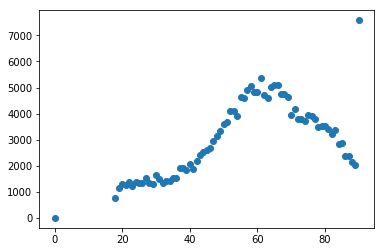

In [3]:
# Shows age distribution of the data set. There are 3 0-olds and 7579 90 year olds. 
# Implies that over nineties were grouped together
ages = trainDf['Age'].value_counts()
plt.scatter(ages.keys(),ages.values)

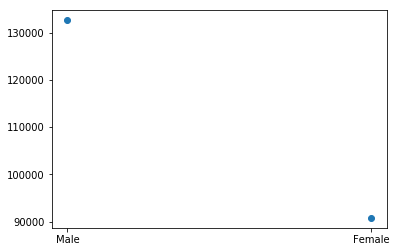

In [4]:
gender = rawDf['Sex'].value_counts()
plt.scatter(gender.keys(),gender.values)

-1.0    201033
 1.0     22380
Name: No Finding, dtype: int64


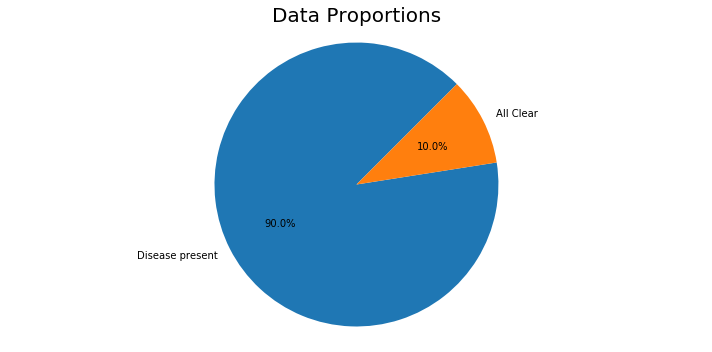

In [5]:
# How many people have no disease?
no_finding = rawDf['No Finding'].value_counts()
print(no_finding)

# Plot pie chart to show how much of the data is labelled with each character
values = no_finding.values
labels = ['Disease present','All Clear']

# Plot
plt.figure(figsize=(10, 5))
plt.title('Data Proportions', size=20)
plt.pie(values, labels=labels, # explode=explode,
        autopct='%1.1f%%', shadow=False, startangle=45)
 
plt.axis('equal')
plt.tight_layout()
plt.show()



In [6]:
trainDf

,Patient ID,Study,Path,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Sex_Female,Sex_Male,Frontal/Lateral_Frontal,Frontal/Lateral_Lateral
0,00001,1,CheXpert-v1.0-small/train/patient00001/study1/...,68,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.0,-1.0,-1.0,-1.0,1.0,1,0,1,0
1,00002,2,CheXpert-v1.0-small/train/patient00002/study2/...,87,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1,0,1,0
2,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1,0,1,0
3,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1,0,0,1
4,00003,1,CheXpert-v1.0-small/train/patient00003/study1/...,41,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0,1,1,0
5,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,1.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1,0,1,0
6,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,1.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1,0,0,1
7,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,1.0,-1.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.0,-1.0,-1.0,1.0,0,1,1,0
8,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,1.0,-1.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.0,-1.0,-1.0,1.0,0,1,0,1
9,00005,2,CheXpert-v1.0-small/train/patient00005/study2/...,33,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0,1,1,0


In [7]:
img_paths = trainDf['Path'].tolist()

In [8]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    return files


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (x, x, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [9]:
train_tensors = paths_to_tensor(img_paths[:2000]).astype('float32')/255

In [10]:


model = Sequential()

model.add(Conv2D(64, (4,4),  strides=3, input_shape=(224,224,3)))
model.add(Conv2D(32, (2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))

model.add(Dense(, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 74, 74, 64)        3136      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dense_2 (Dense)              (None, 133)               8645      
Total params: 2,674,277
Trainable params: 2,674,277
Non-trainable params: 0
_________________________________________________________________
